In [73]:
import tensorflow as tf
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline

In [74]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

!tar xvf VOCtrainval_06-Nov-2007.tar
!tar xvf VOCtest_06-Nov-2007.tar

!rm VOCtrainval_06-Nov-2007.tar
!rm VOCtest_06-Nov-2007.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2007/JPEGImages/000725.jpg
VOCdevkit/VOC2007/JPEGImages/000727.jpg
VOCdevkit/VOC2007/JPEGImages/000732.jpg
VOCdevkit/VOC2007/JPEGImages/000734.jpg
VOCdevkit/VOC2007/JPEGImages/000735.jpg
VOCdevkit/VOC2007/JPEGImages/000736.jpg
VOCdevkit/VOC2007/JPEGImages/000737.jpg
VOCdevkit/VOC2007/JPEGImages/000741.jpg
VOCdevkit/VOC2007/JPEGImages/000743.jpg
VOCdevkit/VOC2007/JPEGImages/000744.jpg
VOCdevkit/VOC2007/JPEGImages/000745.jpg
VOCdevkit/VOC2007/JPEGImages/000747.jpg
VOCdevkit/VOC2007/JPEGImages/000749.jpg
VOCdevkit/VOC2007/JPEGImages/000751.jpg
VOCdevkit/VOC2007/JPEGImages/000757.jpg
VOCdevkit/VOC2007/JPEGImages/000758.jpg
VOCdevkit/VOC2007/JPEGImages/000759.jpg
VOCdevkit/VOC2007/JPEGImages/000762.jpg
VOCdevkit/VOC2007/JPEGImages/000765.jpg
VOCdevkit/VOC2007/JPEGImages/000766.jpg
VOCdevkit/VOC2007/JPEGImages/000769.jpg
VOCdevkit/VOC2007/JPEGImages/000773.jpg
VOCdevkit/VOC2007/JPEGImages/000775.jpg
VOCdevkit/VOC2007/JPEGImages/

In [75]:
import argparse
import xml.etree.ElementTree as ET
import os

parser = argparse.ArgumentParser(description='Build Annotations.')
parser.add_argument('dir', default='..', help='Annotations.')

sets = [('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}


def convert_annotation(year, image_id, f):
    in_file = os.path.join('VOCdevkit/VOC%s/Annotations/%s.xml' % (year, image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        classes = list(classes_num.keys())
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        f.write(' ' + ','.join([str(a) for a in b]) + ',' + str(cls_id))

In [76]:
for year, image_set in sets:
  print(year, image_set)
  with open(os.path.join('VOCdevkit/VOC%s/ImageSets/Main/%s.txt' % (year, image_set)), 'r') as f:
      image_ids = f.read().strip().split()
  with open(os.path.join("VOCdevkit", '%s_%s.txt' % (year, image_set)), 'w') as f:
      for image_id in image_ids:
          f.write('%s/VOC%s/JPEGImages/%s.jpg' % ("VOCdevkit", year, image_id))
          convert_annotation(year, image_id, f)
          f.write('\n')

2007 train
2007 val
2007 test


In [77]:
import cv2 as cv
import numpy as np

def read(image_path, label):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_h, image_w = image.shape[0:2]
    image = cv.resize(image, (100, 100))
    image = image / 255.

    label_matrix = np.zeros([7, 7, 30])
    for l in label:
        l = l.split(',')
        l = np.array(l, dtype=np.int64)
        xmin = l[0]
        ymin = l[1]
        xmax = l[2]
        ymax = l[3]
        cls = l[4]
        x = (xmin + xmax) / 2 / image_w
        y = (ymin + ymax) / 2 / image_h
        w = (xmax - xmin) / image_w
        h = (ymax - ymin) / image_h
        loc = [7 * x, 7 * y]
        loc_i = int(loc[1])
        loc_j = int(loc[0])
        y = loc[1] - loc_i
        x = loc[0] - loc_j

        if label_matrix[loc_i, loc_j, 24] == 0:
            label_matrix[loc_i, loc_j, cls] = 1
            label_matrix[loc_i, loc_j, 20:24] = [x, y, w, h]
            label_matrix[loc_i, loc_j, 24] = 1  # response

    return image, label_matrix

In [78]:
from tensorflow import keras

class My_Custom_Generator(keras.utils.Sequence) :

  def __init__(self, images, labels, batch_size) :
    self.images = images
    self.labels = labels
    self.batch_size = batch_size


  def __len__(self) :
    return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int64)


  def __getitem__(self, idx) :
    batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    train_image = []
    train_label = []

    for i in range(0, len(batch_x)):
      img_path = batch_x[i]
      label = batch_y[i]
      image, label_matrix = read(img_path, label)
      train_image.append(image)
      train_label.append(label_matrix)
    return np.array(train_image), np.array(train_label)

In [79]:
train_datasets = []
val_datasets = []

with open(os.path.join("VOCdevkit", '2007_train.txt'), 'r') as f:
    train_datasets = train_datasets + f.readlines()
with open(os.path.join("VOCdevkit", '2007_val.txt'), 'r') as f:
    val_datasets = val_datasets + f.readlines()

X_train = []
Y_train = []

X_val = []
Y_val = []

for item in train_datasets:
  item = item.replace("\n", "").split(" ")
  X_train.append(item[0])
  arr = []
  for i in range(1, len(item)):
    arr.append(item[i])
  Y_train.append(arr)

for item in val_datasets:
  item = item.replace("\n", "").split(" ")
  X_val.append(item[0])
  arr = []
  for i in range(1, len(item)):
    arr.append(item[i])
  Y_val.append(arr)

In [80]:
batch_size = 4
my_training_batch_generator = My_Custom_Generator(X_train, Y_train, batch_size)

my_validation_batch_generator = My_Custom_Generator(X_val, Y_val, batch_size)

x_train, y_train = my_training_batch_generator.__getitem__(0)
x_val, y_val = my_training_batch_generator.__getitem__(0)
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(4, 100, 100, 3)
(4, 7, 7, 30)
(4, 100, 100, 3)
(4, 7, 7, 30)


In [81]:
from tensorflow import keras
import keras.backend as K

class Yolo_Reshape(tf.keras.layers.Layer):
  def __init__(self, target_shape, **kwargs):
    print("get_config")
    super(Yolo_Reshape, self).__init__(**kwargs)
    self.target_shape = tuple(target_shape)

  def get_config(self):
    print("get_config")
    config = super().get_config().copy()
    config.update({
        'target_shape': self.target_shape
    })
    return config

  def call(self, input):
    print("call")
    print(input.shape)
    print(len(input))
    print("here")
    # grids 7x7
    S = [self.target_shape[0], self.target_shape[1]]
    # classes
    C = 20
    # no of bounding boxes per grid
    B = 2

    idx1 = S[0] * S[1] * C
    idx2 = idx1 + S[0] * S[1] * B

    # class probabilities
    class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))
    class_probs = K.softmax(class_probs)

    #confidence
    confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
    confs = K.sigmoid(confs)

    # boxes
    boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
    boxes = K.sigmoid(boxes)

    outputs = K.concatenate([class_probs, confs, boxes])
    return outputs

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1
grid_w=7
grid_h=7
cell_w=64
cell_h=64
img_w=grid_w*cell_w
img_h=grid_h*cell_h

model = Sequential()
model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(1, 1), input_shape =(img_w, img_h, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(1470, activation='sigmoid'))
model.add(Yolo_Reshape(target_shape=(7,7,30)))
model.summary()

get_config
call
(None, 1470)
Tensor("yolo__reshape_6/strided_slice:0", shape=(), dtype=int32)
here
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 448, 448, 64)      9472      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 224, 224, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 224, 224, 192)     110784    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 192)     0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 112, 112, 128)     24704     
                     

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1
grid_w=7
grid_h=7
cell_w=64
cell_h=64
img_w=grid_w*cell_w
img_h=grid_h*cell_h

model = Sequential()
model.add(Conv2D(filters=64, kernel_size= (3, 3), input_shape =(100, 100, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=96, kernel_size= (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size= (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size= (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size= (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1470, activation='sigmoid'))
model.add(Yolo_Reshape(target_shape=(7,7,30)))
model.summary()

get_config
call
(None, 1470)
Tensor("yolo__reshape_7/strided_slice:0", shape=(), dtype=int32)
here
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 50, 50, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 50, 50, 96)        55392     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 25, 25, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 25, 25, 64)        55360     
                     

In [84]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [85]:
import keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

In [86]:
# defining a function to save the weights of best model
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [87]:
from tensorflow import keras

model.compile(loss=yolo_loss ,optimizer='adam')

In [88]:
model.fit(x=my_training_batch_generator,
          steps_per_epoch = int(len(X_train) // batch_size),
          epochs = 1,
          verbose = 1,
          workers= 4,
          validation_data = my_validation_batch_generator,
          validation_steps = int(len(X_val) // batch_size),
           callbacks=[
              CustomLearningRateScheduler(lr_schedule),
              mcp_save
          ])


Epoch 00000: Learning rate is 0.0100.
call
(None, 1470)
Tensor("sequential_4/yolo__reshape_7/strided_slice:0", shape=(), dtype=int32)
here
call
(None, 1470)
Tensor("sequential_4/yolo__reshape_7/strided_slice:0", shape=(), dtype=int32)
here
625/625 [==============================] - ETA: 0s - loss: 59.4338call
(None, 1470)
Tensor("sequential_4/yolo__reshape_7/strided_slice:0", shape=(), dtype=int32)
here
get_config
625/625 [==============================] - 150s 231ms/step - loss: 59.4338 - val_loss: 59.1572


In [89]:
import cv2 as cv
import numpy as np

def load_and_preprocess_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    original_image = image.copy()
    image_h, image_w = image.shape[0:2]
    image = cv.resize(image, (100, 100))  # Assuming your model was trained with this size
    image = image / 255.0
    return image, original_image, image_h, image_w

In [90]:
image_path = '/content/carbird.jpeg'  # Replace with your image file
img, original_img, orig_h, orig_w = load_and_preprocess_image(image_path)
print(img.shape)
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    for k in range(img.shape[2]):
      print(img[i][j][k])

Streaming output truncated to the last 5000 lines.
0.13725490196078433
0.00784313725490196
0.6196078431372549
0.13333333333333333
0.03137254901960784
0.5803921568627451
0.11764705882352941
0.00784313725490196
0.6039215686274509
0.15294117647058825
0.0392156862745098
0.6
0.13725490196078433
0.027450980392156862
0.6078431372549019
0.12156862745098039
0.023529411764705882
0.6039215686274509
0.14901960784313725
0.00784313725490196
0.592156862745098
0.15294117647058825
0.00392156862745098
0.596078431372549
0.15294117647058825
0.00392156862745098
0.6039215686274509
0.16470588235294117
0.00392156862745098
0.592156862745098
0.14901960784313725
0.0
0.5764705882352941
0.13333333333333333
0.0
0.5843137254901961
0.1450980392156863
0.0
0.5882352941176471
0.1450980392156863
0.0
0.5843137254901961
0.1450980392156863
0.0
0.5725490196078431
0.12941176470588237
0.0
0.5725490196078431
0.12941176470588237
0.0
0.5803921568627451
0.13725490196078433
0.0
0.592156862745098
0.14901960784313725
0.00392156862745

In [91]:
img = np.expand_dims(img, axis=0)  # Model expects a batch dimension

In [92]:
predictions = model.predict(img)

call
(None, 1470)
Tensor("sequential_4/yolo__reshape_7/strided_slice:0", shape=(), dtype=int32)
here


1/1 [==============================] - 1s 637ms/step


In [93]:
predictions.shape

(1, 7, 7, 30)

In [94]:
class_names = {value: key for key, value in classes_num.items()}

def decode_predictions(predictions, image_h, image_w):
    grid_size = 7
    num_boxes = 2
    num_classes = 20
    predictions = predictions.reshape((grid_size, grid_size, 30))

    boxes = []

    for i in range(grid_size):
        for j in range(grid_size):
            for b in range(num_boxes):
                tx, ty, tw, th, confidence = predictions[i, j, b*5:(b+1)*5]
                cx = (j + tx) * image_w / grid_size
                cy = (i + ty) * image_h / grid_size
                w = image_w * np.exp(tw) / grid_size
                h = image_h * np.exp(th) / grid_size
                classes = predictions[i, j, 10:]
                class_id = np.argmax(classes)
                class_score = classes[class_id]
                score = confidence * class_score

                if score > 0.06:  # Confidence threshold
                    class_name = class_names[class_id]
                    boxes.append((cx, cy, w, h, class_name, score))

    return boxes


decoded_boxes = decode_predictions(predictions[0], orig_h, orig_w)

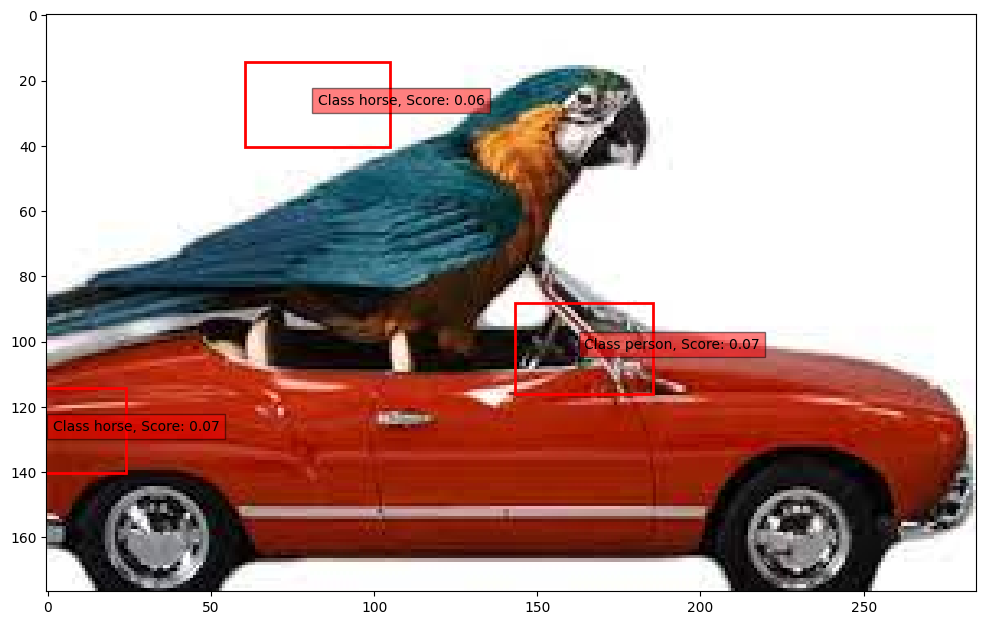

In [95]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_boxes(image, boxes):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box in boxes:
        cx, cy, w, h, cls, score = box
        rect = patches.Rectangle((cx - w / 2, cy - h / 2), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(cx, cy, f'Class {cls}, Score: {score:.2f}', bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

draw_boxes(original_img, decoded_boxes)

In [96]:
print(model.trainable_variables)

[<tf.Variable 'conv2d_58/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[-0.07631405,  0.16065344,  0.1390392 , ..., -0.0088227 ,
           0.05548763, -0.09399959],
         [-0.1423405 ,  0.12165167,  0.04620031, ...,  0.06733885,
           0.04123233,  0.0482037 ],
         [-0.13022292,  0.09284811,  0.1361634 , ...,  0.10938342,
           0.06835677,  0.10434702]],

        [[-0.04194758,  0.10716068,  0.02570263, ..., -0.04722613,
           0.08430535,  0.07975837],
         [-0.07400328,  0.16206068,  0.05129071, ...,  0.14621358,
           0.16302384,  0.00044896],
         [ 0.02416377,  0.00155078,  0.01852112, ...,  0.12409303,
           0.09039104,  0.02320976]],

        [[-0.0789863 ,  0.0968579 , -0.02102472, ...,  0.12751858,
           0.07080268,  0.0298725 ],
         [-0.15215026,  0.05357666,  0.05087841, ...,  0.11295764,
           0.07502332,  0.05902992],
         [-0.13265342,  0.17277122, -0.00256325, ...,  0.08588362,
          -0.0115029

In [97]:
model.save_weights('/content/model_weights.h5')

In [98]:
def get_activations(model, inputs):
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(inputs)
    return activations

# Perform inference and get activations
activations = get_activations(model, img)

# Print the output of each layer
for i, activation in enumerate(activations):
    print(f"Layer {i}: {activation.shape}:  {activation}")

call
(None, 1470)
Tensor("model_2/yolo__reshape_7/strided_slice:0", shape=(), dtype=int32)
here
1/1 [==============================] - 0s 214ms/step
Layer 0: (1, 100, 100, 64):  [[[[0.         0.9260988  0.90397877 ... 0.69009095 1.2829999
    0.86602944]
   [0.         1.1787199  1.5076029  ... 1.0587739  1.7698411
    1.3205538 ]
   [0.         1.1787199  1.5076029  ... 1.0587739  1.7698411
    1.3205538 ]
   ...
   [0.         1.1787199  1.5076029  ... 1.0587739  1.7698411
    1.3205538 ]
   [0.         1.1787199  1.5076029  ... 1.0587739  1.7698411
    1.3205538 ]
   [0.         0.71485966 1.0937414  ... 0.6631175  1.135176
    0.91230863]]

  [[0.         1.5200769  1.0267838  ... 1.2395314  1.7550431
    1.0938133 ]
   [0.         2.1478512  1.9518106  ... 1.7761139  2.4069614
    1.6068888 ]
   [0.         2.1478512  1.9518106  ... 1.7761139  2.4069614
    1.6068888 ]
   ...
   [0.         2.1478512  1.9518106  ... 1.7761139  2.4069614
    1.6068888 ]
   [0.         2.1478512  1

In [99]:
print(len(activations))
print(activations[13].shape)
print(activations[14].shape)

15
(1, 1470)
(1, 7, 7, 30)


In [100]:
for i in range(activations[13].shape[1]):
  print(activations[13][0][i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [101]:
activations[13].shape

(1, 1470)

In [102]:
yolo_reshape_layer = Yolo_Reshape(target_shape=(7, 7, 30))

# Assuming 'activations' is a list with outputs from each layer
final_dense_output = activations[13]  # Output from the final Dense layer

# Pass the output through the Yolo_Reshape layer
reshaped_output = yolo_reshape_layer(final_dense_output)

# Convert the tensor to a numpy array for printing
reshaped_output_numpy = reshaped_output.numpy()

# Print the reshaped output
print("Output of Yolo_Reshape Layer:")
print(reshaped_output_numpy)

get_config
call
(1, 1470)
1
here
Output of Yolo_Reshape Layer:
[[[[0.04604416 0.04604416 0.04604416 ... 0.7310586  0.5
    0.5       ]
   [0.04604416 0.04604416 0.04604416 ... 0.5        0.7310586
    0.5       ]
   [0.02461879 0.06692081 0.06692081 ... 0.7310586  0.7310586
    0.5       ]
   ...
   [0.04604416 0.04604416 0.04604416 ... 0.7310586  0.5
    0.5       ]
   [0.04604416 0.04604416 0.04604416 ... 0.7310586  0.5
    0.5       ]
   [0.06987673 0.06987673 0.06987673 ... 0.7310586  0.7310586
    0.7310586 ]]

  [[0.02963292 0.02963292 0.08055062 ... 0.7310586  0.5
    0.7310586 ]
   [0.02819718 0.02819718 0.02819718 ... 0.5        0.5
    0.5       ]
   [0.03122271 0.08487212 0.08487212 ... 0.7310586  0.5
    0.5       ]
   ...
   [0.07310585 0.02689414 0.02689414 ... 0.7310586  0.5
    0.7310586 ]
   [0.04266837 0.11598466 0.04266837 ... 0.5        0.7310586
    0.5       ]
   [0.04604416 0.04604416 0.04604416 ... 0.5        0.5
    0.5       ]]

  [[0.02689414 0.07310586 0.073

In [103]:
print(orig_h, orig_w)

177 285


In [104]:
decoded_boxes = decode_predictions(reshaped_output_numpy[0], orig_h, orig_w)

In [105]:
original_img.shape

(177, 285, 3)

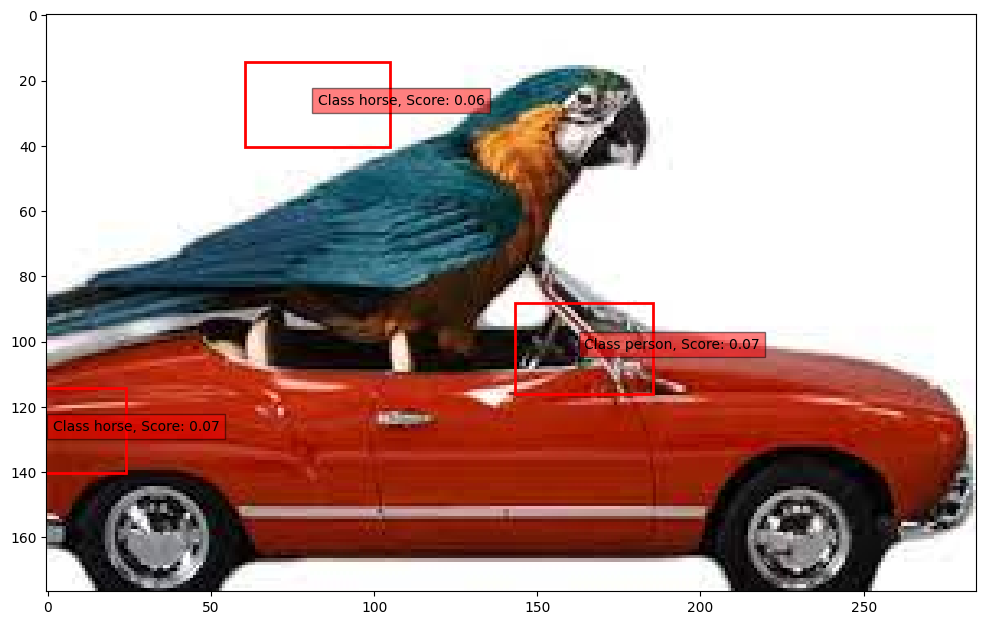

In [106]:
draw_boxes(original_img, decoded_boxes)

In [107]:
model.save_weights('model_weights.h5')

# Save entire model
model.save('model.h5')

get_config


In [108]:
from tensorflow.keras.models import load_model

# Load entire model
loaded_model = load_model('/content/model.h5', custom_objects={'Yolo_Reshape': Yolo_Reshape})

# Load model weights
loaded_model.load_weights('/content/model_weights.h5')

get_config
call
(None, 1470)
Tensor("yolo__reshape_7/strided_slice:0", shape=(), dtype=int32)
here


ValueError: Unknown loss function: 'yolo_loss'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.